IMPORTANT: behavior annotation with Chris's fran code are zero-based!!!

addition to the code: 

1) read in a single/ few data sets and read all datasets (for cellConfig and behavior_transition)

2) check if I really have solved the timestamp issue

3) check if all csv files exists

4)!!! ratio to entcounter for less activity in the end

------------------------------------------------------------------------------

This script was build for analysis of neuronal avtivity data in combination with behavioral annotations. 

Multiple csv-files (behavior, dff, time_stamp, neuronal activity (lm-data)) are combined in a single dataframe per experiment (sample_df). The identity of the sample is kept by introducing a sample-ID (date, number of sample) and an experiment-ID (imaging acquisition type <close and open loop>). Kind of behavior is predefined and extended with 'quiet'. Data of behavior, as well time-data are combined with all lm data. To define the start end end, as well accoiunt for overlapping events of the same behavior, a start, end, and overlap column is added for each behavior.

In [1]:
# Import libraries and implement error messages (Default should be True)
# To make the plot in the notebook and not in an extra window
%matplotlib notebook 

import csv
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker
import pandas as pd
import glob, os
import re

error_on_missing_timestamps = False
error_on_time_light_mismatch = False
error_on_time_behavior_mismatch = False
error_on_missing_behaviors = False
error_on_invalid_behavior_range = False

In [2]:
#Open multiple .csv from single directory. Define existing behaviors. Define sample_ID and experiment_ID.

#directory for behavior data
behavior_directory = r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/behavior_csv/' # directory for behavioral annotations
behavior_files = glob.glob(os.path.join(behavior_directory, "*.csv")) #join pathname with filename

# Behavior columns available in CSV files
available_behaviors = ('fw', 'bw', 'stim', 'hunch', 'turn', 'other', 'HP', 'left turn', 'right turn')

#Regular expression (define the expression filenames are searched for)
#'.' single character, matched everything, '*' 0>> occurences, '/' path delimiter, '\d' 0-9 digit,
#'+' 1>> occurences, 'L' here character from filename
#() outcome here: 2 groups, useful for extraction
#[] optional list, eg 1 --> 1
#? character non or once 

#Behavior reg-ex (regular expression)
behavior_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-behavior-(.+).csv')

# Function: readall_behavior iterates through all csv (sorted) 
# and appends the files into the list (ls) and returns dictionary
def readall_behavior(all_files, printit=False):
    data = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # exp_id = DETAIL: several measurements of same sample 
        # (cl (closeloop, RGECO/ Chronos), ol (openloop, RGECO/ Chronos), 
        # blocks (Raghav: GCaMP/Chrimson))
        # Larva ID: YY-MM-DDLX
        # Look for filename_components, which are true for pattern
        match = behavior_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        #define filename_components sample_id (first group), and exp_id (sec group)
        part_sample_id, _, exp_id = filename_components         
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        df = pd.read_csv(filename, index_col=None, header=0, delimiter = ';')
        df.fillna(0, inplace=True) #replace NaN with zero
        df['sample_id'] = sample_id  #add sample_id column
        df['exp_id'] = exp_id #add exp_id column
        data[sample_id] = df
        #Count 'True' for each column ('behavior') in each single behavior.csv)
        #print(filename, df[df == 1].count()) 
        #print(df)
    return data

behavior_data = readall_behavior(behavior_files)
#print(behavior_data['17-08-26L3-cl'])



In [3]:
# Frequency of each behavior in all imported behavior.csv by using the returned 'ls' from 
# the function readAll: concatenate the 'behavior_files' (global variable). 'True' for each 
# column ('behavior_type') in the concatenated file (df_behavior).
# Sorting has to be = False (warning message without 'sort')
df_behavior = pd.concat(behavior_data.values(), axis = 0, ignore_index = True, sort = False) #add sorting
print(df_behavior[df_behavior == 1].count()) 

START           11
END              0
fw            5128
bw             926
stim           353
hunch          444
turn          2196
other          183
HP             790
left turn     1104
right turn    1093
sample_id        0
exp_id           0
stimulus         4
dtype: int64


In [4]:
# Import and merge fluorescence data: Several LM files for the same sample_id exists, but differ in cell_id).
# List of LM data with two extra columns: sample_id and cell_id

    #Mapping of sampleID vs lists of LM dataframes
    #Convert list to a single dataframe
    #Map with df_behavior (later done)

# Open LM files from different directories
lightmicroscope_directories = [r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/Basin_traces/', 
                               r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/Handle-like_Traces',
                               r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/a00c_traces'
                              ] 

# Iterate through LM data and extend files in a list from within and between directory and 
# build a list of files from all directories
# (Note: append would 'extend' lists and not single files)
lightmicroscope_files = []
for d in lightmicroscope_directories:
    lightmicroscope_files.extend(
        glob.glob(os.path.join(d, "*.csv"))) #join pathname with filename, 
                                                                       
# Regular expression (define the expression filenames are searched for)
# '.' single character, matched everything, '*' 0>> occurences, '/' path delimiter, '\d' 0-9 digit,
# '+' 1>> occurences, 'L' here character from filename
# () outcome here: 2 groups, useful for extraction

# Lightmicroscopic data reg-ex (regular expression)
lightmicroscope_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-(.*)-(.*).csv')

# Function: readall_lm iterates through all LM_csv (sorted) 
# and returns a dictionary{key:value} 
# samples = {sample_id:cell-id}
def readall_lm(all_files):
    samples = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # Larva ID: YY-MM-DDLX, DETAIL = cell_id
        #look for filename_components, which are true for pattern
        match = lightmicroscope_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        part_sample_id, _, cell_id, exp_id = filename_components
        
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        # Read LM.files 
        df = pd.read_csv(filename, index_col=None, header=0, delimiter = ',')
        # Replace NaN with zero
        df.fillna(0, inplace=True)
        
        # Add cellname to each column as prefix
        # lambda is a non defined function (longer version: def lambda(x):)
        # Rename of columns after the format cell_id, name) eg: Basin A9
        # inplace = True: column names are overwritten (if False: new dataframe)
        df.rename(lambda x: '{}_{}'.format(cell_id, x), axis = 'columns', inplace = True)
        
        # Get the sample_id (key) from the dictionary? to make a list [sample_cells] and 
        # if sample_id exists, append the list
        # if sample_id does not exists, start a new list
        # reminder: there can be several cell_id per sample_id
        sample_cells = samples.get(sample_id)
        if not sample_cells:
            samples[sample_id] = sample_cells = {
                'data': [],
                'exp_id': exp_id,
            }
        sample_cells['data'].append(df)
        
    return samples

lm_samples = readall_lm(lightmicroscope_files)

# New dictionary: lm_data{} to build a single dataframe with all cell_ids combined 
# for a single sample. Iterate over dict (samples)? and data from same sample in 
# one dataframe. 
# df.items iterate over pairs and build a list

lm_data = {}

# Iterate over all light samples and merge all found files
# for each sample into a single data frame (per sample)
for sample_id, sample_info in lm_samples.items():
    cells_dataframes = sample_info['data']
    #check if number of cells >= 1
    if not cells_dataframes:
        raise ValueError('No cells found for sample {}'.format(sample_id))
    #first element in the list
    lm_df = None

    #iteration through other df
    for cdf in cells_dataframes:
        if lm_df is None:
            lm_df = cdf
        else:
            if len(lm_df.index) != len(cdf.index):
                raise ValueError('Data frame frame to merge has not same row count as target', sample_id)
            lm_df = pd.merge(lm_df, cdf, left_index = True, right_index = True)
            
    lm_df['sample_id'] = sample_id  #add sample_id column
    lm_df['exp_id'] = sample_info['exp_id']
    lm_data[sample_id] = lm_df
#print(list(lm_data.keys()))

In [5]:
# Import txt-files from of the absolute time/frame from the Ca-imaging (lm-data). 
# All txt-files have to be transposed, which is a memory intensive step. After the 
# data are complete, the transposed files should be exported (ToDo). Time-data are 
# combined with sample-ID and experiment-ID.

timelapse_directory =(r'/Users/randeln/Documents/Zlatic_lab/close-loop/Notes/timelapse/') 
timelapse_files = glob.glob(os.path.join(timelapse_directory, "*.txt")) #join pathname with filename


# Regular expression (define the expression filenames are searched for)
# '.' single character, matched everything, '*' 0>> occurences, '/' path delimiter, '\d' 0-9 digit,
# '+' 1>> occurences, 'L' here character from filename
# () outcome here: 2 groups, useful for extraction
# [] optional list, eg 1 --> 1
# ? character non or once 

# Behavior reg-ex (regular expression)
time_sample_re = re.compile('.*/(\d\d-\d\d-\d\dL\d+(-\d+)?)-time-(.+).txt')

# Function: readall_timelapse iterates through all txt (sorted) and appends the 
# files into the dict (data) and returns ls
def readall_time(all_files, printit=False):
    data = {}
    for filename in sorted(all_files):
        # Find sample ID, file name pattern: YY-MM-DDLXDETAIL.csv,
        # exp_id = DETAIL: several measurements of same sample (cl (closeloop), ol (openloop), blocks (Raghav))
        # Larva ID: YY-MM-DDLX
        #look for filename_components, which are true for pattern
        match = time_sample_re.match(filename)
        if not match:
            raise ValueError('Unexpected filename format: {}'.format(filename))
        filename_components = match.groups()
        part_sample_id, _, exp_id = filename_components #define filename_components sample_id (first group), and exp_id (sec group)  
        sample_id = "{}-{}".format(part_sample_id, exp_id)
        
        df = pd.read_csv(filename, header=1, index_col=None, delim_whitespace = True)
        df = df.T #transposing because read_csv imports as row
        df = df.reset_index() #transpose function sets data as index
        df.rename(columns={'index':'time'}, inplace=True) #rename reset index column to time
        df['time'] = df.time.astype(float)
        data[sample_id] = df
        
    return data

time_data = readall_time(timelapse_files)

In [6]:
sample_data = {}

# Time data are merged into light data and checked if number length of lm = timestamp.  
# Due to technical conditions, some time.txt-file have too many or not enough time data compared
# to the corresponding LM data. The discrepancy is fixed by either dropping the extra timepoints or 
# by taking the average of the difference between each timepoint and extend the dataframe. 
# The first 10 timepoints are not included to account for instability of the microscope in 
# the beginning due to the moving parts. 
# Maximal difference between timepoints fyi.

for sample_id, sample_df in lm_data.items():
    # Add time stamps to data frame of current sample by merging
    # The time data frame for the current sample, which is expected
    # to match the light data (based on index).
    timestamp_df = time_data.get(sample_id)
    if timestamp_df is None:
        msg = '{}: could not find timestamp data for sample'.format(sample_id)
        if error_on_missing_timestamps:
            raise ValueError(msg)
        # Ignore, if missing data shouldn't cancel the whole process.
        print(msg)
        continue
        
    n_timestamps = len(timestamp_df)
    n_lightdata = len(sample_df)
    
    # The timestamp and light recordings are done by different systems.
    # This can cause the existence of additional time points/ or missing time points in a
    # dataset, which will be filtered out in the merge operation below.
    if n_lightdata != n_timestamps:
        msg = '{}: time data ({} entries) doesn\'t match light data ({} entries)'.format(
                sample_id, n_timestamps, n_lightdata)
        if error_on_time_light_mismatch:
            raise ValueError(msg)
        print(msg)
        diffs = np.diff(timestamp_df['time'])[10:] #from 10th row onwards
        diffs_avg = diffs.mean(axis=0)
        #diff between timedata and lightdata
        missing_data = len(sample_df) - len(timestamp_df)
        
        #add 'diffs_avg' to fill in missing_timedata
        if missing_data > 0:
            last_valid_index = len(timestamp_df) - 1
            last_timestamp = timestamp_df.iloc[last_valid_index]['time']
            if pd.isna(last_timestamp):
                raise ValueError('Unexpected last valid timestamp for sample {} at index {}'.format(
                        sample_id, last_valid_index))
            for i in range(0, missing_data):
                last_valid_index += 1
                timestamp_df.loc[last_valid_index] = timestamp_df.iloc[last_valid_index - 1]['time'] + diffs_avg
        elif missing_data < 0:
            drop_start = len(timestamp_df) + missing_data
            drop_end = len(timestamp_df)
            timestamp_df.drop(list(range(drop_start, drop_end)))

    # Merge timedata into light data
    # Use an 'inner' join/merge to exclude time points that don't have matching light data.
    new_sample_df = pd.merge(sample_df, timestamp_df, left_index = True, right_index = True, how='inner')
    
    # Store newly created data frame for sample (dictionary)
    sample_data[sample_id] = new_sample_df
    
print('Matched {} light data sets with their respective time points'.format(len(sample_data)))

# Max.diffs for timestamps
diffs = np.diff(timestamp_df['time'])[10:] #from 10th row onwards
mx = diffs.max()
#print(mx)

17-08-24L5-cl: time data (6686 entries) doesn't match light data (6685 entries)
17-08-26L1-cl: time data (6990 entries) doesn't match light data (6989 entries)
17-08-27L2-cl: time data (6470 entries) doesn't match light data (6469 entries)
17-08-28L3-cl: time data (6228 entries) doesn't match light data (6225 entries)
17-08-29L2-cl: time data (6817 entries) doesn't match light data (6805 entries)
17-11-03L7-cl: time data (1399 entries) doesn't match light data (2657 entries)
17-11-04L1-cl: time data (6325 entries) doesn't match light data (6324 entries)
17-11-06L1-cl: could not find timestamp data for sample
17-11-08L3-cl: time data (3240 entries) doesn't match light data (6474 entries)
17-11-26L1-cl: time data (6487 entries) doesn't match light data (6469 entries)
17-11-29L3-cl: time data (6567 entries) doesn't match light data (6561 entries)
17-11-30L2-cl: time data (6640 entries) doesn't match light data (6396 entries)
Matched 76 light data sets with their respective time points


In [8]:
# Combine behavior data with light data into a single data frame
# per sample ID. To do so, add behavior data to light data frames,
# because the light data is already organizes by frame. To accomodate
# frame ranges without an behavior data, a column named "quiet" is
# added which is True in these cases and False otherwise. Additionally,
# for each behavior column, a behavior start and end column as well as
# an overlap column is added so that parallel and successive behaviors
# of the same type can be differentiated.

for sample_id, sample_df in sample_data.items():
    sample_behavior = behavior_data.get(sample_id)
    if sample_behavior is None:
        msg = 'Could not find behavior data for sample "{}"'.format(sample_id)
        if error_on_missing_behaviors:
            raise ValueError(msg)
        print(msg)
        continue

    # Add extra columns for behavior
    for behavior in available_behaviors:
        sample_df[behavior] = False
        sample_df['{}_start'.format(behavior)] = False
        sample_df['{}_end'.format(behavior)] = False
        sample_df['{}_overlap'.format(behavior)] = False
    
    # Add 'quiet' column. Set it initially to True and mark frames
    # with actual behavior as quiet = False.
    sample_df['quiet'] = True
    
    n_light_entries = len(sample_df)

    # Iterate over behavior data and add data to target data frame
    for i, row in sample_behavior.iterrows():
        # Start ane end are 1-based, make them 0-based
        start = int(row['START'])
        end = int(row['END'])
        
        if type(row['START']) == str:
            print(sample_id)
            print(start, end)
        
        if start >= end:
            msg = "{}: start ({}) needs to be strictly smaller than end ({})".format(sample_id, start, end)
            if error_on_invalid_behavior_range:
                raise ValueError(msg)
            print(msg)
            continue
        
        # Make sure we capture start/end times that are a fractional number.
        if row['START'] - start > 0 or row['END'] - end > 0:
            raise ValueError('{}: start and end frame number can\'t contain fractions'.format(sample_id))
            
        # Ignore behavior entries with an end frame higher than available light data.
        # The behavior data is one-based, which is why a strict larger than test should
        # be correct.
        if end > n_light_entries:
            msg = 'Sample: {} - Behavior row with range {}-{} exceeds light time points ({}): {}'.format(
                sample_id, start, end, n_light_entries, row)
            if error_on_time_behavior_mismatch:
                raise ValueError(msg)
            print(msg)
            continue
            
        # Find behavior observed in row
        observed_behaviors = []
        for behavior in available_behaviors:
            if row[behavior]:
                observed_behaviors.append(behavior)
        
        # We assume that not more than two behaviors are observed at the same time
        if len(observed_behaviors) > 2:
            raise ValueError('Found multiple behaviors in row {} of sample {}'.format(i, sample_id))
        
        # Add observed behavior information to target data frames in all
        # rows in behavior range.
        for b in observed_behaviors:
            # Iterate over frames valid for current behavior. Every valid
            # frame is mapped into the canonical (light/cell) data frame,
            # which is 0-indexed.
            for j in range(start, end + 1):
                # Behavior ranges are 1-indexed
                current_frame = j - 1
                # If the current behavior has already been observed at this frame,
                # set overlap to True, because we are about to mark this behavior
                # again as observed for this frame.
                if sample_df.at[current_frame, b]:
                    sample_df.at[current_frame, '{}_overlap'.format(b)] = True
                else:
                    sample_df.at[current_frame, b] = True
                
                # Mark this row as not quiet, because we observed
                # a behavior in the current frame.
                sample_df.at[current_frame, 'quiet'] = False

            sample_df.at[start - 1, '{}_start'.format(b)] = True
            sample_df.at[end - 1, '{}_end'.format(b)] = True
            
    # Mark quiet ranges with _start, _end and _overlap. By definion,
    # quiet_overlap is always False.
    sample_df['quiet_start'] = False
    sample_df['quiet_end'] = False
    sample_df['quiet_overlap'] = False
    last_sample_idx = n_light_entries - 1
    for i, row in sample_df.iterrows():
        sample_df.at[i, 'quiet_start'] = row['quiet'] and (i == 0 or not sample_df.at[i - 1, 'quiet'])
        sample_df.at[i, 'quiet_end'] = row['quiet'] and (i == last_sample_idx or not sample_df.at[i + 1, 'quiet'])

TypeError: unsupported operand type(s) for -: 'str' and 'int'

The above generated dataframe per sample (sample_df) including lm data, behavior, time and sample_id/exp_id, and the extended cell-names and extra behavioral columns can be analysed in the following section.

Class will be defined, including sample_id, cell_type, event (type), and filter pattern. This 
allows to extract information throughout all samples about activity pattern (lm-data) 
of a specific celltype (including sub-type) and event_start (=behavior). 

For single sample: cell_subset_df 
        allows visualisation of whole experimantal time, and extract/ visualized information around a specific
        event, which are aligned and normalized (event_start = zero). An adjustable time-window around the 
        event_start of interested is included. 
    - avg, max, min, stdev and sem can be direct calculated from the data (for whole timeseries)
    - But if events are aligned, same problem as with multiple samples
        
For multiple combined samples (no additional processing): all_events
        extract/ visualized information around a specific
        event, which are aligned and normalized (event_start = zero). An adjustable time-window around the
        event_start of interested is included. 

    The samples are imaged (Ca-imaging) with different imaging speed, and therefore a direct comparison between the 
    samples is not possible. Following things have to be considered:
    
                    ToDo!!!
    
        - If the data are analysed as raw data (all_events) there are many NaN in the data set, and also the same 
        timestamp is duplicated for each individual sample
        - avg, max, min, stdev and sem can not be direct calculated from the data, because(?) vergessen:(
        
        - For some analysis (), the samples should be aligned: For now we use interpolation after index. 
        THAT HAS TO BE CHECKED!!!  
        
        - alternatives: underlying fitting curve

In [100]:
#Define a class with sample_id, cell_type, event_name and filter_pattern
class CellTraceConfig:
    
    def __init__(self, sample_id, cell_type, event_name, filter_pattern=None):
        self.sample_id = sample_id
        self.cell_type = cell_type
        self.event_name = event_name
        self.filter_pattern = filter_pattern
        
    def get_filter_regex(self):
        filter_regex = '^{}_'.format(self.cell_type)
        if self.filter_pattern:
            filter_regex += '.*{}.*'.format(self.filter_pattern)
        return filter_regex
    
    def get_event_start_col(self):
        return '{}_start'.format(self.event_name)

    def add_event_time_points_to_plot(self, source_df, plot):
        for idx, row in source_df.iterrows():
            plot.annotate(self.event_name, xy=(row['time'], 1))
            plt.axvline(row['time'], color='k', linestyle='-')  
            
#Define a class with sample_id, cell_type, event_time and filter_pattern
class CellTransConfig:
    
    def __init__(self, sample_id, cell_type, event_time, filter_pattern=None):
        self.sample_id = sample_id
        self.cell_type = cell_type
        self.event_time = event_time
        self.filter_pattern = filter_pattern
        
    def get_filter_regex(self):
        filter_regex = '^{}_'.format(self.cell_type)
        if self.filter_pattern:
            filter_regex += '.*{}.*'.format(self.filter_pattern)
        return filter_regex

In [101]:
# Allows to load specific samples (single samples) with specific filter pattern

cell_trace_configs = [
    #CellTraceConfig('17-08-26L6-cl', 'basin', 'stim'),
    #CellTraceConfig('17-08-26L1-cl', 'A00c', 'stim'),
    #CellTraceConfig('17-08-26L2-cl', 'A00c', 'stim'),
    CellTraceConfig('17-08-23L2-cl', 'A00c', 'stim', 'mid'),
    #CellTraceConfig('17-08-26L6-cl', 'A00c', 'stim'),
    #CellTraceConfig('17-08-24L2-1-cl', 'A00c', 'stim'),
    #CellTraceConfig('17-08-24L2-2-cl', 'A00c', 'stim', 'mid'),
    #CellTraceConfig('17-08-24L5-cl', 'A00c', 'stim', 'mid')
]
'''
# Allows to load all samples with specific filter pattern
cell_trace_configs = [
    CellTraceConfig(name,'A00c', 'fw') for name in lm_data]
'''

# Allow to load all samples with specific filter pattern
# ToDo

all_events = [] #List of events, with raw dff data (no interpolation or other 
                #processing done at this point). Sample_id is added to the cell name. 

for ctc in cell_trace_configs:
    sample_df = sample_data.get(ctc.sample_id)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue    
    # Extract columns matching our cell type and the optional filter pattern.
    # Pandas' filter() operations works on columns for DataFrames by default.
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    cell_subset_df.reset_index(inplace = True) # Add index and time = column
    #print(ctc.sample_id, cell_subset_df)   
    # Get rows where current event starts.
    event_df = sample_df[sample_df.loc[:,ctc.get_event_start_col()]]
    print(event_df)
    # Gives the timestamp for the event_df (start)
    for idx, row in event_df.iterrows():
        print('TP of {} ='.format(ctc.event_name), row['time'])
        
    # Extract for specific time window and align several events. 
    # Define timepoints pre and post an event (event_df). 
    # This works for single sample or multiple samples aligned 
    # Note: In cell_subset_df, time was set to index, because for the previous avg calculation 
    # Add index and time = column

    # Set the window range left and right from the event
    left_half_window_size = 1.0 #in seconds
    right_half_window_size = 2.0

    # Event_df defined in pargraph before 
    windows = []
    n_behavior = 0
    for i,row in event_df.iterrows():
        n_behavior += 1
        window_start = row['time'] - left_half_window_size
        window_end = row['time'] + right_half_window_size
        
        # Get subset of rows between window_start and window_end       
        event = cell_subset_df[(cell_subset_df.time >= window_start) & (cell_subset_df.time <= window_end)]
        # Normalizing the data to align on beginning of selected
        # behavior (event_df = Zero) by substracting events in window
        # around start of event of interest from start of event interest.
        # Note: using ":" in event.loc[] will select "all rows" in our window.
        event.loc[:, 'time'] = event['time'] - row['time']

        # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
        event.rename(lambda x: '{}_{}_{}'.format(ctc.sample_id, x, n_behavior), 
                     axis = 'columns', inplace = True) 

        # Rename time collum to time
        event.rename(columns={ event.columns[0]: 'time' }, inplace = True) 
        all_events.append(event) # Append a list with all event
        
        #Round (NR)
        #decimals = 1    
        #event['time'] = event['time'].apply(lambda x: round(x, decimals))
        
        
# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_df = all_events.pop(0)
for right_df in all_events:
    all_df = pd.merge_ordered(all_df, right_df, on="time", how="outer")

# Resets the index as time and drops time column (sollte spaeter kommen)
all_df.index = all_df["time"]
del all_df["time"]        
#print(all_df)

#NR
# Index intepolation (linear interpolatione not on all_df, because index [=time] is not eaqually distributed)
int_all_df = all_df.interpolate(method='index', axis=0, limit=None, inplace=False, limit_direction='both')
#print(int_all_df)


      basin_A9R  basin_A8L  basin_A8L.1  basin_A8L.2  basin_A7R  basin_A7R.1  \
114    0.225119   0.173794     0.062910     0.078601   0.173627     0.184527   
2471   0.116503   0.066573     0.067759     0.055078   0.064738     0.061164   
4644   0.082456   0.095302     0.062948     0.061173   0.084827     0.075009   

      basin_A7R.2  basin_A8R  basin_A8R.1  basin_A8R.2  ...  left turn_end  \
114      0.127424   0.070045     0.084679     0.047897  ...          False   
2471     0.071283   0.048988     0.047576     0.022003  ...          False   
4644     0.084452   0.060648     0.085960     0.061187  ...          False   

      left turn_overlap  right turn  right turn_start  right turn_end  \
114               False       False             False           False   
2471              False       False             False           False   
4644              False       False             False           False   

      right turn_overlap  quiet  quiet_start  quiet_end  quiet_overlap  


single sample, over whole experimental time
- does not have much meaningfulness

single sample, aligned for events
...

In [102]:
    # Single sample -analysis
    # For single sample over the whole experimental time
    # Note: multiple sample-comparison need more pre-processing(see below)
    # Calculate min, max, avg, stddev, sem from cell_subset_df (defined earlier)
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    del cell_subset_df['time'] # delete time_column
    cell_subset_df.index.name = None # delete index name
    cell_avg_df = cell_subset_df.mean(axis=1)
    cell_min_df = cell_subset_df.min(axis=1)
    cell_max_df = cell_subset_df.max(axis=1)
    # Standard deviation (distribution)
    cell_std_df = cell_subset_df.std(axis = 1)
    #standard error of mean
    cell_sem_df = cell_subset_df.sem(axis = 1)
    #print(ctc.sample_id, cell_avg_df) #OK


# For single or multiple sample, aligned for certain event
#Average is wrongly applied, because it avg all events and all cells pro tp
# Good! NaN are ignored and the correct avg is calculated
all_cell_avg_df = int_all_df.mean(axis=1) # Interpolated data used
all_cell_min_df = int_all_df.min(axis=1)
all_cell_max_df = int_all_df.max(axis=1)
# Standard deviation (distribution)
all_cell_std_df = int_all_df.std(axis = 1)
#standard error of mean
all_cell_sem_df = int_all_df.sem(axis = 1)
#print(all_cell_avg_df) #wrong zur haelfte: Want to have avg per celltyp over time point, 
                        #and not avg over all cells per timepoint

<IPython.core.display.Javascript object>


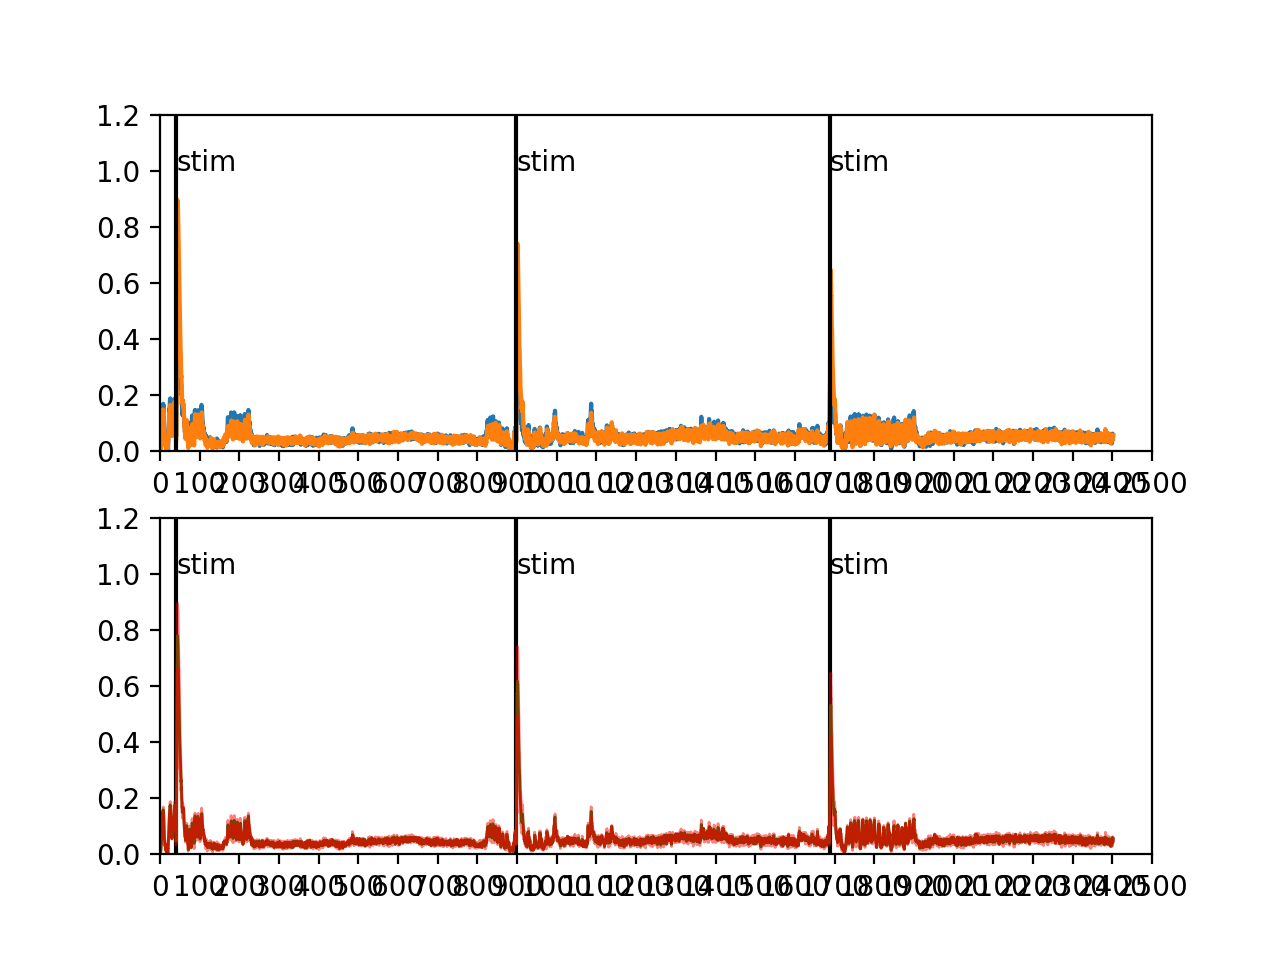

In [103]:
%matplotlib notebook
from matplotlib import pyplot as plt
plt.rcParams["axes.grid"] = False

# Plotting - single sample 
def layout_plot(plot, tick_spacing=100, fov=(0, 2500, 0, 1.2), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

# Get rows where current event is active and draw a vertical 
# line to indicate the event in the plot
event_df = sample_df[sample_df.loc[:,ctc.get_event_start_col()] == 1]
fig = plt.figure()
fig.set_facecolor("white")

# Plot all cells from cell_subset_df over entire time (specified in Cell_Trace_Config).
sub1 = fig.add_subplot(211) #211
cell_subset_df.plot(ax=sub1)
ctc.add_event_time_points_to_plot(event_df, sub1)
layout_plot(sub1)

# Avg, min, max, std-dev for multiple cells in single sample over whole time
sub2 = fig.add_subplot(212)#212
ctc.add_event_time_points_to_plot(event_df, sub2)
cell_avg_df.plot(ax=sub2, color = 'g', label = ctc.cell_type, linewidth=1)
cell_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
cell_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#cell_avg_df.plot.line(yerr=cell_std_df, ax=sub2, color = 'r', alpha = 0.1)
#cell_avg_df.plot.line(yerr=cell_sem_df, ax=sub2, color = 'c', alpha = 0.1)
layout_plot(sub2)


<IPython.core.display.Javascript object>


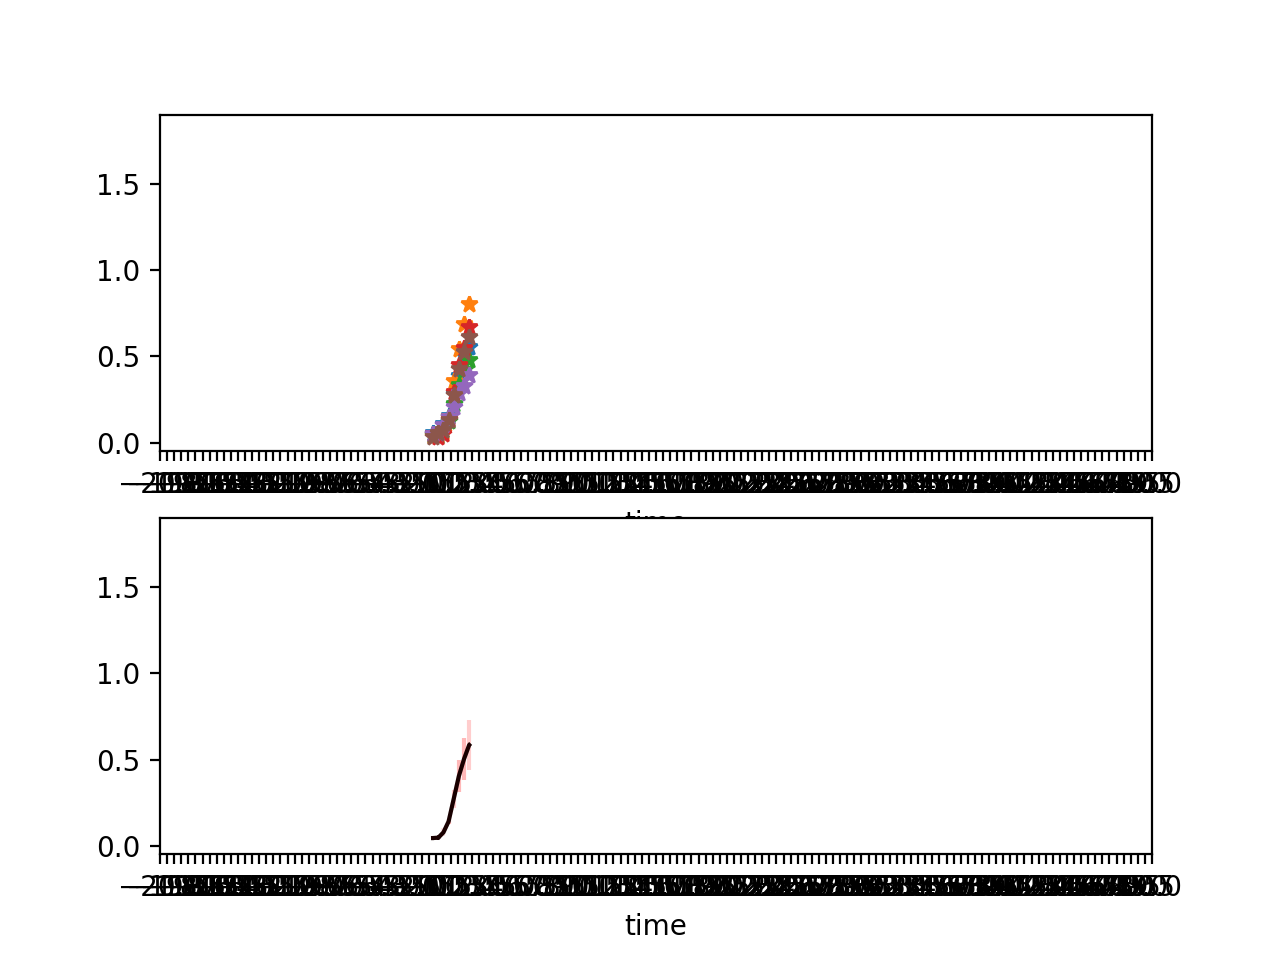

In [104]:
# Note: HERE FOR PLOTTING THE ALIGNED EVENT, INDEPENDENT OF PRO AND / OR POST_EVENT
# (should be after transition_event)

# Plotting for multi-events (all_df) (raw_dff_data)
# If a dataframe with NANs is plotted, use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points
def aligned_layout_plot(plot, tick_spacing=0.5, fov=(-20, 50, -0.05, 1.9), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

# Plot all cells from all_df, aligned at zero for event_start, specified in Cell_Trace_Config.
sub1 = fig.add_subplot(211)
all_df.plot(ax=sub1, marker = '*', label = ctc.cell_type)
aligned_layout_plot(sub1)

sub2 = fig.add_subplot(212)
all_cell_avg_df.plot(ax=sub2, color = 'k', label = ctc.cell_type) #use interpolated df to calculate average...
#all_cell_min_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
#all_cell_max_df.plot(ax=sub2, color = 'r', linewidth=1, alpha = 0.5)
all_cell_avg_df.plot.line(yerr=all_cell_std_df, ax=sub2, color = 'r', alpha = 0.1)
#all_cell_avg_df.plot.line(yerr=all_cell_sem_df, ax=sub2, color = 'c', alpha = 0.1)
aligned_layout_plot(sub2)




The following part extract the information about behavior transition under certain limitation:
1) Find second_behavior, and extract information if the defined first_behavior happens within a max_delay.
2) Find first_behavior, and extract information if the defined second_behavior happens within a max_delay.
3) Find second_behavior, and extract information if the defined first_behavior and third_behavior 
   happens within a max_delays.
4) Find first_behavior, and extract information if the same second_behavior happens within a max_delay. Note: So far no overlap cases detected. Code for overlap cases could not be verified.

In [ ]:
class PreBehaviorTransition:
    
    def __init__(self, sample_id, pre_event, event, max_delay=0):
        self.sample_id = sample_id
        self.pre_event = pre_event
        self.event = event
        self.max_delay = max_delay

def find_behavior_after(sample_id, sample_df, first_event, second_event, max_delay=0):
    """For the data frame of a single sample <df>, find all behaviors
    of type <second_event> that follow the event <first_event>,
    separated by <max_delay> time. The start of <first_event> is expected
    to happen strictly before the start of <second_event>. The end time
    of <first_event> however can overlap with the start time of <second_event>.
    In this case, the time difference is negative, and still smaller than
    <max_delay>. The end time of <first_event> can be before, at or after the
    end of <second_event>.
    
    TODO: If <first_event> and <second_event> are the same type of behavior,
    overlaps have to be taken into account to match start and end times
    to the correct event.
    """
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    first_event_overlap_col = '{}_overlap'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    
    first_event_start_time = None
    first_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    
    for i, row in sample_df.iterrows():
        # Look for end of first behavior and remember its time.
        if row[first_event_start_col]:
            first_event_start_time = row['time']
        if row[first_event_end_col] and not row[first_event_overlap_col]:
            first_event_end_time = row['time']
        if row[second_event_start_col]:
            second_event_start_time = row['time']
        if row[second_event_end_col]:
            second_event_end_time = row['time']
        
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_start_time, first_event_end_time,
                    second_event_start_time, second_event_end_time):
            continue
            
        #NR
        # Define rules for event_start_time and event_end_time
        if first_event_start_time > second_event_start_time:
            continue
        if first_event_start_time > first_event_end_time:
            continue
        if second_event_start_time > second_event_end_time:
            continue
        
            
        if abs(first_event_start_time - second_event_start_time) < 0.00001:
            print('{}: start time (first) event {} and start time of (second) event {} are the same: {}'.format(
                sample_id, first_event, second_event, first_event_start_time))

        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed.
        if (second_event_start_time - first_event_end_time) <= max_delay:
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time,
                'second_event_end': second_event_end_time
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = None
        first_event_end_time = None
        second_event_start_time = None
        second_event_end_time = None
            
    return results

behavior_transitions = [
    PreBehaviorTransition('17-08-26L1-cl', 'turn', 'bw', 11),
    #PreBehaviorTransition('17-08-26L6-cl', 'turn', 'bw', 3)
]

found_transitions = []
for bt in behavior_transitions:
    sample_df = sample_data.get(bt.sample_id)
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_after(bt.sample_id, sample_df, bt.pre_event, bt.event, bt.max_delay)
    found_transitions.append(transitions)

print(len(found_transitions))
print(found_transitions)

In [ ]:
class PostBehaviorTransition:
    
    def __init__(self, sample_id, event, post_event, max_delay=0):
        self.sample_id = sample_id
        self.post_event = post_event
        self.event = event
        self.max_delay = max_delay

def find_behavior_before(sample_id, sample_df, first_event, second_event, max_delay=0):
    """For the data frame of a single sample <df>, find all behaviors
    of type <first_event> that is followed by the event <second_event>,
    separated by <max_delay> time. The end of <second_event> is expected
    to happen strictly after the end of <first_event>. The start time
    of <second_event> however can overlap with the end time of <first_event>.
    In this case, the time difference is negative, and still smaller than
    <max_delay>. The start time of <second_event> can be before, at or after the
    end of <first_event>.
    
    TODO: If <first_event> and <second_event> are the same type of behavior,
    overlaps have to be taken into account to match start and end times
    to the correct event.
    """
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    second_event_overlap_col = '{}_overlap'.format(second_event)
    
    first_event_start_time = None
    first_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    
    for i, row in sample_df.iterrows():
        # Look for start of second behavior and remember its time.
        if row[second_event_start_col] and not row[second_event_overlap_col]:
            second_event_start_time = row['time']
        if row[first_event_end_col]:
            first_event_end_time = row['time']
        if row[first_event_start_col]:
            first_event_start_time = row['time']
        
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_start_time, first_event_end_time,
                    second_event_start_time):
            continue
        
        #NR
        # Define rules for event_start_time and event_end_time
        if first_event_start_time > second_event_start_time:
            continue
        if first_event_start_time > first_event_end_time:
            continue
        
        # Test if first_event_start_time = second_event_start_time
        if abs(first_event_start_time - second_event_start_time) < 0.00001:
            print('{}: start time (first) event {} and start time of (second) event {} are the same: {}'.format(
                sample_id, first_event, second_event, first_event_start_time))

        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed.
        if (second_event_start_time - first_event_end_time) <= max_delay:
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = None
        first_event_end_time = None
        second_event_start_time = None
        second_event_end_time = None
            
    return results

# Open single samples (!see CellConfig!) >ToDo
behavior_transitions = [
    #PostBehaviorTransition('17-08-26L1-cl', 'turn', 'bw', 11),
    PostBehaviorTransition('17-08-26L2-cl', 'stim', 'fw', 5),
    #PostBehaviorTransition('17-08-26L5-cl', 'stim', 'fw', 5),
    PostBehaviorTransition('17-08-26L6-cl', 'stim', 'fw', 5)
]
'''
# Open all samples (!see CellConfig!) >ToDo
behavior_transitions = [
    PostBehaviorTransition(name,'stim', 'fw', 3) for name in lm_data]
'''
found_transitions = []
for bt in behavior_transitions:
    sample_df = sample_data.get(bt.sample_id)
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_before(bt.sample_id, sample_df, bt.event, bt.post_event, bt.max_delay)
    found_transitions.append(transitions)

#print(len(found_transitions)) #number of data sets not the actual stim
#print(len(transitions)) #not what I want ToDo
print(found_transitions)

In [77]:
'''
# Get index and time=column
cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
cell_subset_df.reset_index(inplace = True) # Add index and time = column
print(sample_id, cell_subset_df)
'''

'\n# Get index and time=column\ncell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells \ncell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)\ncell_subset_df.reset_index(inplace = True) # Add index and time = column\nprint(sample_id, cell_subset_df)\n'

In [98]:
# Merged ordered troughout all samples for 
cell_trans_configs = []
#trans_data = {}

for sample in found_transitions:
    sample_ls_trans = []
    for found_transition in sample:
        #print(found_transition["sample_id"], found_transition["second_event_start"])
        #print(found_transition["sample_id"])
        sample_ls_trans.append(found_transition["second_event_start"])
        cell_trans_configs.append(CellTransConfig(found_transition["sample_id"], "A00c", 
                                                  found_transition["second_event_start"], "mid"))
                        
    #Find row of found_transition['second_event_start'] in sample_df
    #sample_df = sample_data.get(found_transition["sample_id"])
    #trans_df = sample_df.loc[sample_df['time'].isin(sample_ls_trans)]
    #trans_data[found_transition["sample_id"]] = trans_df
    #print(trans_df, found_transition["sample_id"])

# Extract for specific time window and align several events. 
# Define timepoints pre and post an event (event_df). 
# This works for single sample or multiple samples aligned 
# Note: In cell_subset_df, time was set to index, because for the previous avg calculation 
# Add index and time = column


# Set the window range left and right from the event
left_half_window_size = 1.0 #in seconds
right_half_window_size = 2.0

# trans_df defined in pargraph before 
windows = []
n_behavior = 0

for ctc in cell_trans_configs:
    sample_df = sample_data.get(ctc.sample_id)
    if trans_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue    
    # Extract columns matching our cell type and the optional filter pattern.
    # Pandas' filter() operations works on columns for DataFrames by default.
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    cell_subset_df.reset_index(inplace = True) # Add index and time = column
    #print(cell_subset_df)
    
    n_behavior += 1
    window_start = ctc.event_time - left_half_window_size
    window_end = ctc.event_time + right_half_window_size
        
    # Get subset of rows between window_start and window_end       
    trans = cell_subset_df[(cell_subset_df.time >= window_start) & (cell_subset_df.time <= window_end)]
    # Normalizing the data to align on beginning of selected
    # behavior (event_df = Zero) by substracting events in window
    # around start of event of interest from start of event interest.
    # Note: using ":" in event.loc[] will select "all rows" in our window.
    trans.loc[:, 'time'] = trans['time'] - row['time']

    # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
    trans.rename(lambda x: '{}_{}_{}'.format(ctc.sample_id, x, n_behavior), 
                     axis = 'columns', inplace = True) 

    # Rename time collum to time
    trans.rename(columns={ trans.columns[0]: 'time' }, inplace = True) 
    all_trans_events.append(trans) # Append a list with all event
#print(all_trans_events)    # wrong. Takes the wrong sample
        
        
# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_trans_df = all_trans_events.pop(0)
for right_df in all_trans_events:
    all_trans_df = pd.merge_ordered(all_trans_df, right_df, on="time", how="outer")

# Resets the index as time and drops time column (sollte spaeter kommen)
all_trans_df.index = all_trans_df["time"]
del all_trans_df["time"]        
#print(all_trans_df)

#NR
# Index intepolation (linear interpolatione not on all_df, because index [=time] is not eaqually distributed)
int_all_trans_df = all_trans_df.interpolate(method='index', axis=0, limit=None, inplace=False, limit_direction='both')
print(int_all_trans_df)


           17-08-23L2-cl_A00c_midL_3  17-08-23L2-cl_A00c_midR_3  \
time                                                              
-1637.676                   0.275417                   0.276755   
-1637.356                   0.275417                   0.276755   
-1637.035                   0.275417                   0.276755   
-1636.714                   0.275417                   0.276755   
-1636.394                   0.275417                   0.276755   
-1636.074                   0.275417                   0.276755   
-1635.753                   0.275417                   0.276755   
-1635.432                   0.275417                   0.276755   
-1635.113                   0.275417                   0.276755   
-1634.791                   0.275417                   0.276755   
-1633.111                   0.275417                   0.276755   
-1632.755                   0.275417                   0.276755   
-1632.398                   0.275417                   0.27675

In [ ]:
class BehaviorTransition:
    
    def __init__(self, sample_id, pre_event, event, post_event,
                 pre_max_delay=0, post_max_delay=0):
        self.sample_id = sample_id
        self.pre_event = pre_event
        self.event = event
        self.post_event = post_event
        self.pre_max_delay = pre_max_delay
        self.post_max_delay = post_max_delay

def find_behavior_between(sample_id, sample_df, first_event, second_event,
                          third_event, pre_max_delay=0, post_max_delay=0):
    """For the data frame of a single sample <df>, find all behaviors
    of type <second_event> that a) follows the event <first_event>,
    separated by <pre_max_delay> time. The start of <first_event> is expected
    to happen strictly before the start of <second_event>. The end time
    of <first_event> however can overlap with the start time of <second_event>.
    In this case, the time difference is negative, and still smaller than
    <pre_max_delay>. The end time of <first_event> can be before, at or after the
    end of <second_event>. And b) the behavior <second_event> is followed by the
    event <third_event>, separated by <post_max_delay> time. The end of
    <third_event> is expected to happen strictly after the end of <second_event>.
    The start time of <third_event> however can overlap with the end time of
    <second_event>. In this case, the time difference is negative, and still
    smaller than <post_max_delay>. The start time of <third_event> can be before,
    at or after the end of <second_event>.
    
    The start of <first_event> is expected to happen strictly before the start
    of <third_event>. Apart from this, both <first_event> and <third_event> can
    overlap.
    
    TODO: handle overlaps when behavior types are the same.
    """
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    first_event_overlap_col = '{}_overlap'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    third_event_start_col = '{}_start'.format(third_event)
    third_event_end_col = '{}_end'.format(third_event)
    third_event_overlap_col = '{}_overlap'.format(third_event)
    
    first_event_start_time = None
    first_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    third_event_start_time = None
    third_event_end_time = None

    for i, row in sample_df.iterrows():
        # Look for behaviors and remember its time.
        if row[first_event_start_col] and first_event_start_time is None:
            first_event_start_time = row['time']
            first_event_end_time = None
            continue
        if row[first_event_end_col] and not row[first_event_overlap_col]:
            first_event_end_time = row['time']
        if row[second_event_start_col]:
            second_event_start_time = row['time']
            second_event_end_time = None
        if row[second_event_end_col]:
            second_event_end_time = row['time']
        if row[third_event_start_col] and not row[third_event_overlap_col]:
            third_event_start_time = row['time']
   
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_end_time, second_event_start_time,
                    second_event_end_time, third_event_start_time):
            continue
            
        #NR
        if first_event_start_time > second_event_start_time:
            continue
        if first_event_start_time > first_event_end_time:
            continue
        if second_event_start_time > second_event_end_time:
            continue
        if second_event_start_time > third_event_start_time:
            continue
            
        if abs(first_event_start_time - second_event_start_time) < 0.00001:
            print('{}: start time (first) event {} and start time of (second) event {} are the same: {}'.format(
                sample_id, first_event, second_event, first_event_start_time))
        if abs(second_event_start_time - third_event_start_time) < 0.00001:
            print('{}: start time (second) event {} and start time of (third) event {} are the same: {}'.format(
                sample_id, second_event, third_event, second_event_start_time))

        #print(first_event_start_time, first_event_end_time, second_event_start_time, second_event_end_time, third_event_start_time, third_event_end_time)
        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed.
        if (second_event_start_time - first_event_end_time) <= pre_max_delay \
                and (third_event_start_time - second_event_end_time) <= post_max_delay:
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time,
                'second_event_end': second_event_end_time,
                'third_event_start': third_event_start_time
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = None
        first_event_end_time = None
        second_event_start_time = None
        second_event_end_time = None
        third_event_start_time = None
        third_event_end_time = None

    return results

# Open single sample (!see CellConfig!) >ToDo
behavior_transitions = [
    BehaviorTransition('17-08-26L1-cl', 'bw', 'turn', 'bw', 10, 10),
]

'''
# Open all samples (!see CellConfig!) >ToDo
behavior_transitions = [
    BehaviorTransition(name, 'bw', 'turn', 'bw', 3, 3) for name in lm_data]
'''

found_transitions = []
for bt in behavior_transitions:
    sample_df = sample_data.get(bt.sample_id)
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_between(bt.sample_id, sample_df, bt.pre_event,
                                        bt.event, bt.post_event, bt.pre_max_delay,
                                        bt.post_max_delay)
    if transitions:
        found_transitions.append(transitions)

print(len(found_transitions))
print(found_transitions)

In [ ]:
# All behavior_transitions, which were considered before assume that subsequent behaviors 
# are not the same. For same pairwise (2 behavior), we need to access also the data, when 
# the behaviors are same

class SamePairBehaviorTransition:
    
    def __init__(self, sample_id, pre_event, event, max_delay=0):
        self.sample_id = sample_id
        self.pre_event = pre_event
        self.event = event
        self.max_delay = max_delay

def find_behavior_next(sample_id, sample_df, first_event, second_event, max_delay=0):
    """For the data frame of a single sample <df>, find all behaviors
    of type <first_event> that will be followed by the same event <second_event>,
    separated by <max_delay> time. The start of <first_event> is expected
    to happen strictly before the start of <second_event>. The end time
    of <first_event> however can overlap with the start time of <second_event>.
    In this case, the time difference is negative, and still smaller than
    <max_delay>. The end time of <first_event> can be before, at or after the
    end of <second_event>.
    
    If <first_event> and <second_event> are the same type of behavior,
    overlaps have to be taken into account differently to match start and end times
    to the correct event. During iteration for one loop, we have to exclude the 
    fact that the first_event == second_event.
    """
    
    results = []
    first_event_start_col = '{}_start'.format(first_event)
    first_event_end_col = '{}_end'.format(first_event)
    first_event_overlap_col = '{}_overlap'.format(first_event)
    second_event_start_col = '{}_start'.format(second_event)
    second_event_end_col = '{}_end'.format(second_event)
    second_event_overlap_col = '{}_overlap'.format(second_event) 
    
    first_event_start_time = None
    first_event_end_time = None
    second_event_start_time = None
    second_event_end_time = None
    
    # Check for overlap between the same behaviors (print index, where 'True') and use
    # it as a check that there is not this error in the behavior data
    #print(sample_id, sample_df.index[sample_df['bw_overlap']].tolist())
    
    # Note: The overlap statement was removed. This part has to be 
    # checked if overlapping events are found in the data
    for i, row in sample_df.iterrows():
        # Look for start of first behavior and remember its time.
        if row[first_event_start_col]and first_event_start_time is None:
            first_event_start_time = row['time']
        if row[first_event_end_col] and first_event_end_time is None: 
            first_event_end_time = row['time']
        if row[second_event_start_col]:
            second_event_start_time = row['time']
        if row[second_event_end_col]:
            second_event_end_time = row['time']
        
        # As long as we haven't collected all needed time points,
        # keep on searching.
        if None in (first_event_start_time, first_event_end_time,
                    second_event_start_time, second_event_end_time):
            continue
        
        #NR
        if first_event_start_time == second_event_start_time:
            continue
        if first_event_end_time == second_event_end_time:
            continue
        if first_event_start_time > first_event_end_time:
            continue
        if first_event_start_time > second_event_start_time:
            continue

        
        # Test time between first event end and second event start. If it
        # is smaller than <max_delay>, store start of second event as result.
        # The first event end time being greater than the second event start
        # time, is explicitly allowed. During iteration the first_event == second_event. 
        if (second_event_start_time == first_event_end_time): #NR
            continue
        if (second_event_start_time - first_event_end_time) <= max_delay:
            results.append({
                'sample_id': sample_id,
                'first_event_start': first_event_start_time,
                'first_event_end': first_event_end_time,
                'second_event_start': second_event_start_time,
                'second_event_end': second_event_end_time
            })
        
        # Reset behavior tracking variables to find new pattern match.
        first_event_start_time = None
        first_event_end_time = None
        second_event_start_time = None
        second_event_end_time = None
            
    return results


# Open single sample (!see CellConfig!) >ToDo
behavior_transitions = [
    SamePairBehaviorTransition('17-08-26L1-cl', 'turn', 'turn', 3),
    #SamePairBehaviorTransition('17-08-26L6-cl', 'fw', 'fw', 10)
]

'''
# Open all samples (!see CellConfig!) >ToDo
behavior_transitions = [
    SamePairBehaviorTransition(name, 'bw', 'bw', 30) for name in lm_data]
'''

found_transitions = []
for bt in behavior_transitions:
    sample_df = sample_data.get(bt.sample_id)
    if sample_df is None:
        raise ValueError('No data found for sample {}'.format(bt.sample_id))
    transitions = find_behavior_next(bt.sample_id, sample_df, bt.pre_event, bt.event, bt.max_delay)

    if transitions:
        found_transitions.append(transitions)

print(len(transitions))
print(len(found_transitions))
print(found_transitions)

In [ ]:
'''
#Test Nadine for single sample 

# How do I make sure that ctc is the same I use in the transitions? Can we do a class again???
# how do I link it to the correct behavior_transition (pre, post, middle)??? 
# or at least print out whih one I am currently doing
# if I print out first or second event start I don"t know what is my event (first or second)?!?!
# for the test 170826L1 I don't have enough data points!?!?!?
# How can I print preevent/event/postevent that it does not through an error because it is not defined in all classes
# How I get start column of those events, I am interested in?    
# How to combine it with cellConfig?

transition_events = []     
transition_timestamp = []

# Extract columns matching our cell type and the optional filter pattern. 
#Get subset of cells from CellConfig far above.
csd = sample_df.filter(regex=ctc.get_filter_regex()) 
csd.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
csd.reset_index(inplace = True) # Add index and time = column  

# Define which behavior_transition is used 
# ToDo

#print(bt.pre_event)
#print(bt.event) # Gives the name of the event
#print(bt.post_event)

for transition_list in found_transitions:
    for transition in transition_list:
        #print(transition['first_event_start']) # Time_stamp for first_event_start
        #print(transition['second_event_start']) # Time_stamp for second_event_start
        t = transition['first_event_start'] #this depends on the behavior_transition_type 
        transition_timestamp.append(t) # Append a list with transitions
        #print(transition_timestamp)
            
event_trans = csd.loc[csd['time'].isin(transition_timestamp)]                
        
# Gives the timestamp for the event_trans
for idx, row in event_trans.iterrows():
    print('TP of {} ='.format(bt.event), row['time'])
       
# Extract for specific time window and align several events. 
# Define timepoints pre and post an event (event_trans). 
# This works for single sample or multiple samples aligned 
# Note: In csd, time was set to index
# Add index and time = column
#
# Set the window range left and right from the event
left_half_window_size = 5.0 #in seconds
right_half_window_size = 50.0

# event_trans defined in pargraph before 
windows = []
n_behavior = 0
for i,row in event_trans.iterrows():
    n_behavior += 1
    window_start = row['time'] - left_half_window_size
    window_end = row['time'] + right_half_window_size
        
    # Get subset of rows between window_start and window_end       
    events = csd[(csd.time >= window_start) & (csd.time <= window_end)]
    #print(events)
             
    # Normalizing the data to align on beginning of selected
    # behavior (event_df = Zero) by substracting events in window
    # around start of event of interest from start of event interest.
    # Note: using ":" in event.loc[] will select "all rows" in our window.
    events.loc[:, 'time'] = events['time'] - row['time']
    #print(events) #ok
    # Add sample_id to each column as prefix and n_behavior as suffix to distinguish events within a sample
    events.rename(lambda x: '{}_{}_{}'.format(ctc.sample_id, x, n_behavior), 
                     axis = 'columns', inplace = True) 
    #print(events) 
    # Rename time collum to time
    events.rename(columns={ events.columns[0]: 'time' }, inplace = True)
    #print(events)
    transition_events.append(events) # Append a list with all event
    #print(transition_events)
        
        
# Removes first event and takes it as left_window in pd.merge_ordered and iterates than through all_events
all_transitions = transition_events.pop(0)

for right_df in transition_events:
    all_transitions = pd.merge_ordered(all_transitions, right_df, on="time", how="outer")
    #print(all_transitions)
# Resets the index as time and drops time column
all_transitions.index = all_transitions["time"]
del all_transitions["time"]   
#print(all_transitions)
'''


In [ ]:
#Test Nadine for multiple sample 

# How do I make sure that ctc is the same I use in the transitions? Can we do a class again???
# how do I link it to the correct behavior_transition (pre, post, middle)??? 
# or at least print out whih one I am currently doing
# if I print out first or second event start I don"t know what is my event (first or second)?!?!
# for the test 170826L1 I don't have enough data points!?!?!?
# How can I print preevent/event/postevent that it does not through an error because it is not defined in all classes
# How I get start column of those events, I am interested in?    
# How to combine it with cellConfig?

transition_events = []     
transition_timestamp = []

# Extract columns matching our cell type and the optional filter pattern. 
# Get subset of cells from CellConfig far above. HERE copied from CellTraceConfig
# Allows to load all samples with specific filter pattern

# Next part is repetition but I don't 
cell_trace_configs = [
    CellTraceConfig(name,'A00c', 'stim', 'mid') for name in lm_data]

for ctc in cell_trace_configs:
    sample_df = sample_data.get(ctc.sample_id)
    if sample_df is None:
        raise ValueError('{}: could not find sample data'.format(ctc.sample_id))
        continue
        
    # Extract columns matching our cell type and the optional filter pattern.
    # Pandas' filter() operations works on columns for DataFrames by default.
    cell_subset_df = sample_df.filter(regex=ctc.get_filter_regex()) #Get subset of cells 
    
    cell_subset_df.set_index(sample_df.time, inplace=True) #Set time to index (essential for min/max...)
    cell_subset_df.reset_index(inplace = True) # Add index and time = column
    #print(cell_subset_df)   

    
    #for transition_list in found_transitions: #I need the link which transition!!!
    #    for transition in transition_list:
    #        print(transition['first_event_start']) # Time_stamp for first_event_start
            #print(transition['second_event_start']) # Time_stamp for second_event_start
    #        t = transition['first_event_start'] #this depends on the behavior_transition_type 
    #        transition_timestamp.append(t) # Append a list with transitions
            #print(transition_timestamp)

    #        event_trans = csd.loc[csd['time'].isin(transition_timestamp)]                
        
            # Gives the timestamp for the event_trans
    #for idx, row in event_trans.iterrows():
        #print('TP of {} ='.format(bt.event), row['time'])
       

In [ ]:
# Note: HERE FOR PLOTTING THE ALIGNED EVENT after behavioral_transition filter

# Plotting for multi-events (all_transitions) (raw_dff_data)
# If a dataframe with NANs is plotted, use 
# marker = '+', or 'o', since the line in the lineplot only connects 
# consecutive data points
def aligned_layout_plot(plot, tick_spacing=1.0, fov=(-5, 15, -0.05, 0.8), legend=False): 
    # Set fine x-axis scale
    plot.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))

    # Set x and y limits and legend (default = False) 
    plot.axis(fov)
    plot.legend().set_visible(legend)

fig = plt.figure()

# Plot all cells from all_df, aligned at zero for event_start, specified in Cell_Trace_Config.
sub1 = fig.add_subplot(111)
all_transitions.plot(ax=sub1, marker = '*', label = ctc.cell_type)
aligned_layout_plot(sub1)

#ToDo
#sub2 = fig.add_subplot(212)
#all_transitions_avg_df.plot(ax=sub2, color = 'k', label = ctc.cell_type)
#aligned_layout_plot(sub2)




In [ ]:
#print(list(event_df)) #prints header
#rounded time is only visual, I still get several 'same' tp
#sample_df.round({'time' : 1})
   # Round time on 1 or 2nd decimal
    # the df.round({'time' : 1}) doesn't work if to many decimals
    #decimals = 2    
    #timestamp_df['time'] = timestamp_df['time'].apply(lambda x: round(x, decimals))

In [ ]:
"""
        for k in transition_timestamp:
            a = csd.loc[csd['time'].isin([k])]
            print(a)  """

Overall analysis

In [ ]:
d = {'A' : [3.2, np.nan, np.nan, 5, np.nan, np.nan],
     'B' : [np.nan, 4.1, np.nan, np.nan, 6.2, np.nan], 
     'C' : [np.nan, np.nan, 1.1, np.nan, np.nan, 2.5]}
df = pd.DataFrame(data=d)
print(df)


int_df_linear = df.interpolate(method = 'linear', inplace = False)
print(int_df_linear)

int_df_index = df.interpolate(method='index', inplace=False)
print(int_df_index)
#u = df['T'].unique

# Resets the index as time and drops time column
#df.index = df["T"]
#del df["T"] 

#df.fillna(value=None, method='ffill', axis=None, inplace=False, limit=None, downcast=None) # not what I want
#df.interpolate(method='linear', axis=0, limit=None,
#                      inplace=False, limit_direction='forward', limit_area=None, downcast=None) 


# print out only rows where in'T' are duplicates
#df[df.duplicated(subset= ['T'], keep=False)]

    
    
#np.nanmean(j, axis=0)
#    for j in df.loc[df["T"]== value]:
#        np.nanmean(j, axis=0)


#df.mean(axis=1, skipna=None)
#print(df)
